In [77]:
import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import ast
sns.set(style="whitegrid")
!pip install kmodes
from kmodes.kmodes import KModes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


This project implements a movie recommendation system using keyword and genre-based features from a movie dataset. The system leverages TF-IDF vectorization and k-Nearest Neighbors (kNN) to recommend movies based on a set of input movie IDs. 

# Data Loading and Preparation

In [78]:
Kdf= pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
Kdf.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


keywords list is used to parse list from string

In [79]:
Kdf['keywords'] = Kdf['keywords'].apply(ast.literal_eval)

all_keywords = [keyword['name'] for sublist in Kdf['keywords'] for keyword in sublist]

word_counts = Counter(all_keywords)
n = 180

top_n_words = word_counts.most_common(n)

keyword_df = pd.DataFrame(top_n_words, columns=['Keyword', 'Count'])
Kdf['id'] = Kdf['id'].astype(int)

# Basic analysis

**Display top frequent keywords**

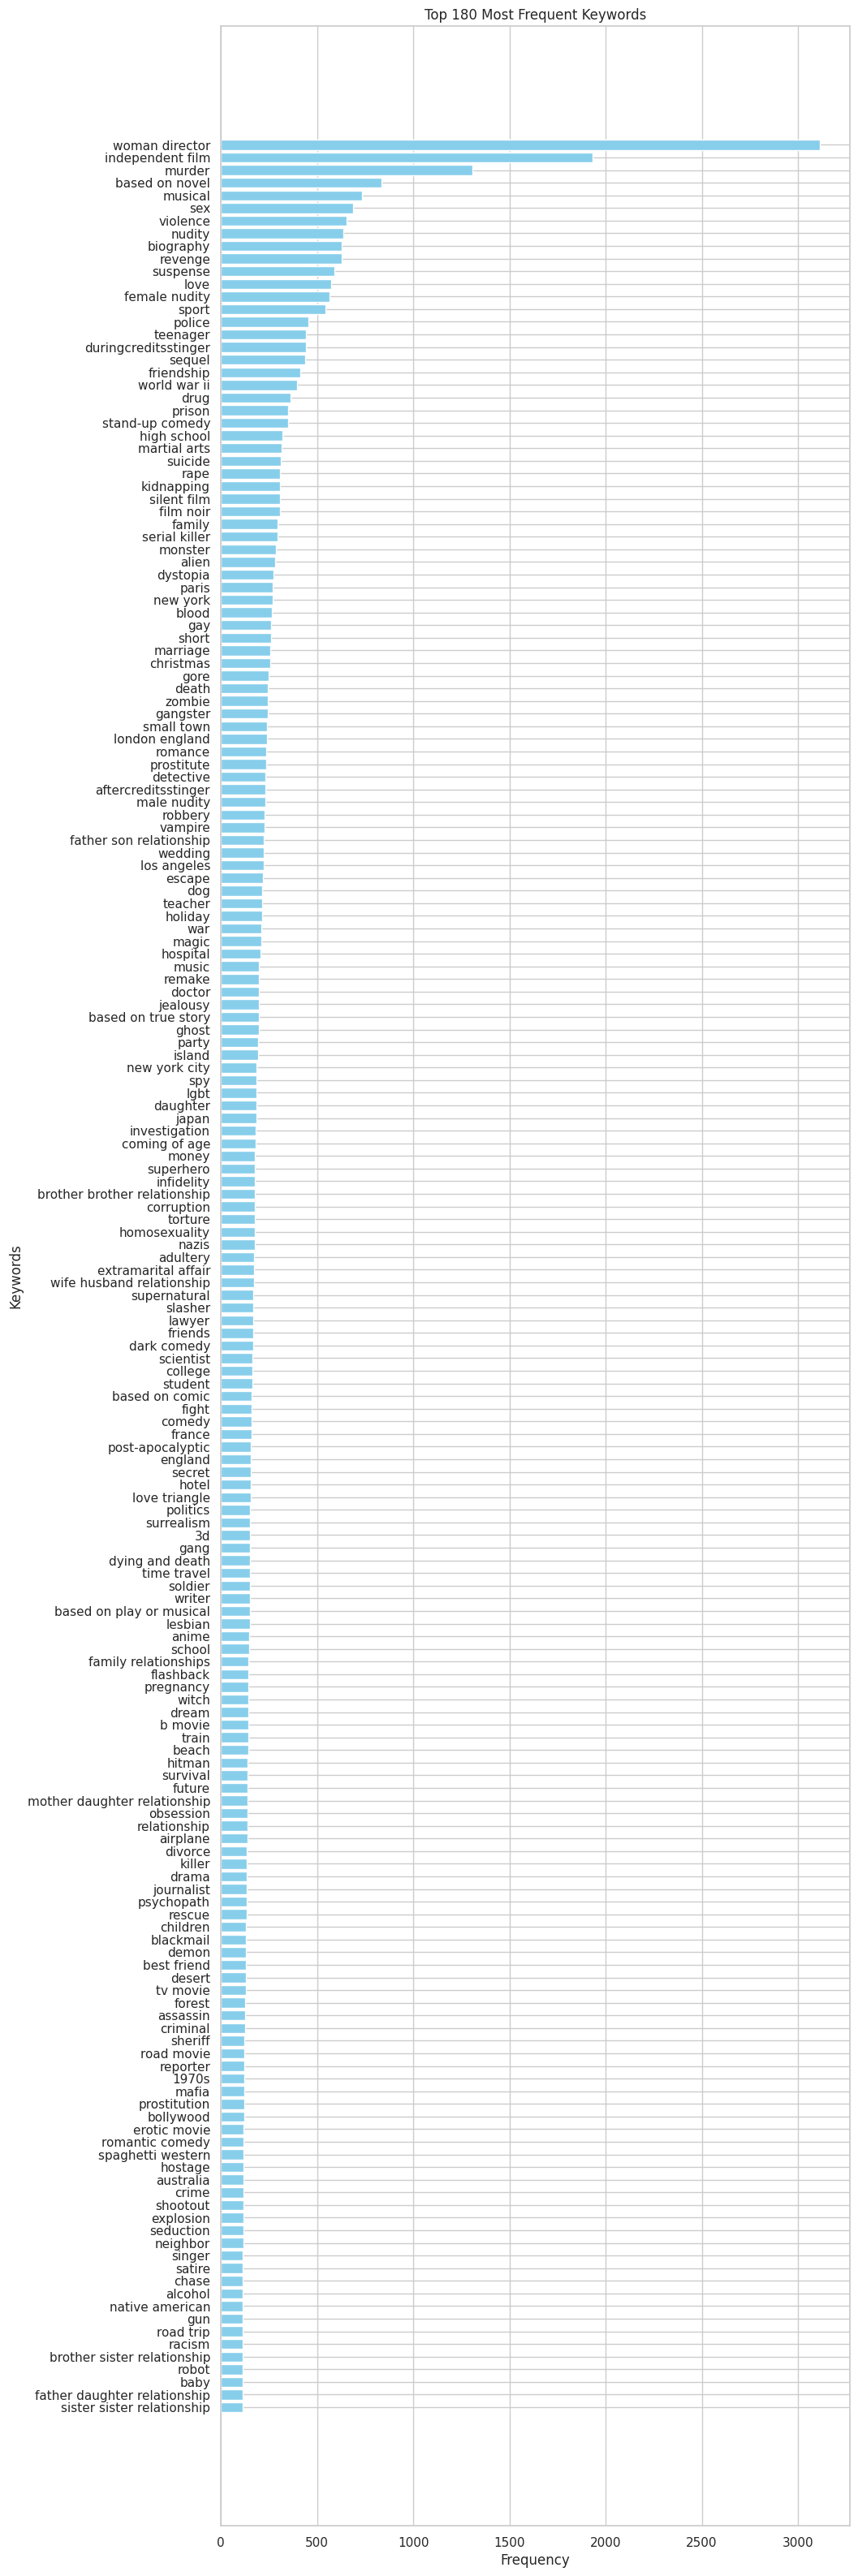

In [7]:
keywords, counts = zip(*top_n_words)

plt.figure(figsize=(10, 40))  
plt.barh(keywords, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.title(f'Top {n} Most Frequent Keywords')

plt.gca().invert_yaxis()

plt.show()

Load csv containing movie metadata and parse genres list from a string

In [80]:
Gdf= pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
Gdf = Gdf[['id', 'genres', 'title','overview']]
Gdf['genres'] = Gdf['genres'].apply(ast.literal_eval)

# Parse 'id' as a numeric type
Gdf['id'] = pd.to_numeric(Gdf['id'], errors='coerce')

Gdf = Gdf.dropna(subset=['id'])

Gdf['id'] = Gdf['id'].astype(int)
Gdf.head()

/tmp/ipykernel_36/3373007864.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  Gdf= pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


,id,genres,title,overview
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,When siblings Judy and Peter discover an encha...
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,Just when George Banks has recovered from his ...


In [81]:

Gdf['title'] = Gdf['title'].astype(str)
column_types = Gdf.dtypes

print(column_types)

id           int64
genres      object
title       object
overview    object
dtype: object


Count occurence of each genre in the dataset:

In [67]:
all_genres = [genre['name'] for sublist in Gdf['genres'] for genre in sublist]

word_counts = Counter(all_genres)
n = 20

top_n_words = word_counts.most_common(n)

genre_df = pd.DataFrame(top_n_words, columns=['Keyword', 'Count'])


**Display top most frequent genres**

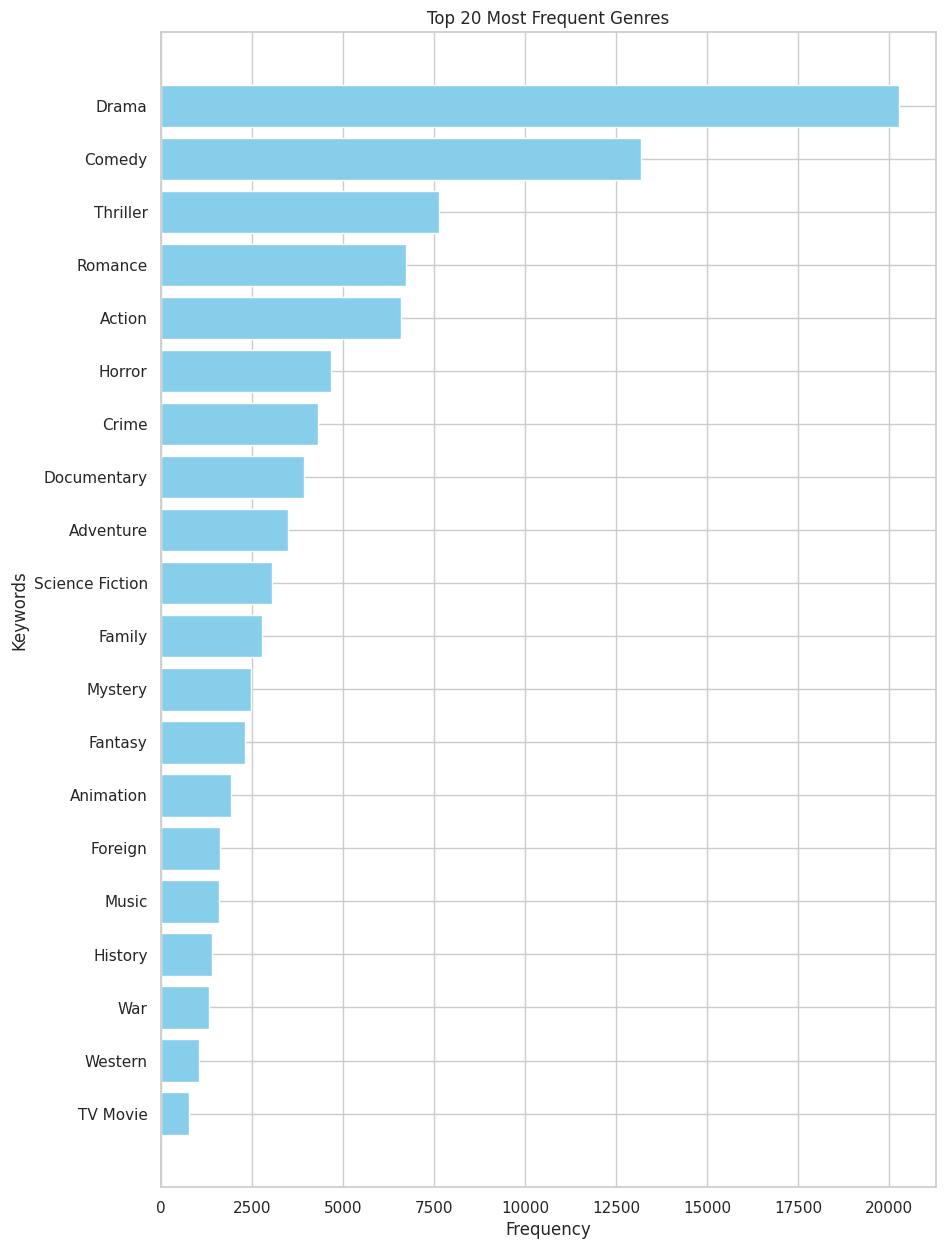

In [13]:

genres, counts = zip(*top_n_words)

plt.figure(figsize=(10, 15))  
plt.barh(genres, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.title(f'Top {n} Most Frequent Genres')

plt.gca().invert_yaxis()

plt.show()

Since the dataset contains a large number of genres and keywords, top 180 keywords and top 20 genres are chosen as relevant features

In [82]:
# join Keyword and Genre counts into a single dataframe
Keywords_df = pd.concat([keyword_df, genre_df], ignore_index=True)



In [15]:
Keywords_df.tail()

,Keyword,Count
195,Music,1598
196,History,1398
197,War,1323
198,Western,1042
199,TV Movie,767


# TF-IDF vectorization 

To use TF-IDF vectorization on the keywords, they are first concatenated into a single string

In [86]:

movie_ids = Kdf['id'].unique()
movie_df = pd.DataFrame({'id': movie_ids})
movie_df['words'] = ""
def Combine(movie_id):
    genres = Gdf.loc[Gdf['id'] == movie_id, 'genres'].values
    keywords = Kdf.loc[Kdf['id'] == movie_id, 'keywords'].values
    
    # Concatenate genres into a single string
    if genres.size == 0:
        genres = []
    else:
        genres = genres[0]
    
    # Concatenate keywords into a single string

    if keywords.size == 0:
        keywords = []
    else:
        keywords = keywords[0]
    
    genre_names = [genre['name'] for genre in genres]
    keyword_names = [keyword['name'] for keyword in keywords]
    
    combined_string = ', '.join(genre_names + keyword_names)
    return combined_string

movie_df['words'] = movie_df['id'].apply(Combine)




convert all strings to lowercase and remove punctuation to standardize data for vectorization

In [28]:
import string
def preprocess_text(text):
    text = text.lower()  
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text



In [29]:
movie_df.head()

,id,words
0,862,animation comedy family jealousy toy boy frien...
1,8844,adventure fantasy family board game disappeara...
2,15602,romance comedy fishing best friend duringcredi...
3,31357,comedy drama romance based on novel interracia...
4,11862,comedy baby midlife crisis confidence aging da...


TF-IDF vectorization transforms the text data into numerical features

In [42]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(movie_df['words'])

kNN is chosen for its simplicity and effectiveness in finding similar items based on feature vectors. The cosine similarity metric is used to measure the angle between vectors, which is effective for text data.

In [53]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn.fit(X)



NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

Example usage for single id

In [54]:
movie_id = 862  # Example movie ID
movie_title = Gdf.loc[Gdf['id'] == movie_id, 'title'].values[0]
movie_idx = movie_df.index.get_loc(movie_df[movie_df['id'] == movie_id].index[0])  

# finds distances to closest feature vectors in the TF-IDF matrix:  
distances, indices = knn.kneighbors(X[movie_idx].reshape(1, -1))

# filter it out if the same movie is recommended
similar_movies = movie_df.iloc[indices[0]]  
similar_movies = similar_movies[similar_movies['id'] != movie_id]  

similar_movies = similar_movies.merge(Gdf[['id', 'title']], on='id', how='left')

print("Distances:", distances)
print("Movie: ", movie_title)
print("Similar Movies:")
print(similar_movies[['id', 'title']])

Distances: [[0.         0.40647336 0.46627502 0.47420671 0.47804248 0.54872029
  0.55361167 0.59211659 0.59951112 0.60009886]]
Movie:  Toy Story
Similar Movies:
       id                            title
0  256835       Toy Story That Time Forgot
1   11551                   Small Soldiers
2   23566  Barbie and the Three Musketeers
3   10193                      Toy Story 3
4   24341                            Dolls
5   10585                     Child's Play
6   11186                   Child's Play 2
7   11359       The Indian in the Cupboard
8    1857      The Transformers: The Movie


To improve recommendations, movies that the user already enjoyed can be used to create a combined vector, and similar movies can be recommended using the collective features of the input movies

# Recommendation algorithm

In [64]:
def recommend_movies(input_movie_ids, n_recommendations=10):
    movie_indices = [movie_df.index.get_loc(movie_df[movie_df['id'] == movie_id].index[0]) for movie_id in input_movie_ids]
    input_movies = movie_df[movie_df['id'].isin(input_movie_ids)].merge(Gdf[['id', 'title']], on='id', how='left')
    print("Input Movies:")
    print(input_movies[['id', 'title']])
    input_vectors = X[movie_indices].toarray()
    combined_vector = np.mean(input_vectors, axis=0)
    
    distances, indices = knn.kneighbors([combined_vector], n_neighbors=n_recommendations + len(input_movie_ids))
    
    similar_movies = movie_df.iloc[indices[0]]  
    similar_movies = similar_movies[~similar_movies['id'].isin(input_movie_ids)] 

    similar_movies = similar_movies.merge(Gdf[['id', 'title','overview']], on='id', how='left')

    return similar_movies[['id', 'title','overview']]

input_movie_ids = [862, 8844, 15602]  # Example movie IDs
recommended_movies = recommend_movies(input_movie_ids)

print("Recommended Movies:")
print(recommended_movies)


Input Movies:
      id             title
0    862         Toy Story
1   8844           Jumanji
2  15602  Grumpier Old Men
Recommended Movies:
       id                                  title  \
0   23566        Barbie and the Three Musketeers   
1  256835             Toy Story That Time Forgot   
2   51249                           Alabama Moon   
3   10193                            Toy Story 3   
4   11551                         Small Soldiers   
5   11520                         Grumpy Old Men   
6  100529                            Lola Versus   
7  136799                                 Trolls   
8  262788                        The Games Maker   
9   33427  LEGO: The Adventures of Clutch Powers   

                                            overview  
0  Join Barbie™ as Corinne™, a young country girl...  
1  During a post-Christmas play date, the gang fi...  
2  After the unexpected death of his survivalist ...  
3  Woody, Buzz, and the rest of Andy's toys haven...  
4  When mi

Save model and created feature matrix

In [87]:
import joblib

joblib.dump(knn, 'knn_model.pkl')

Gdf.to_csv('Gdf.csv', index=False)
movie_df.to_csv('movie_df.csv', index=False)
joblib.dump(X, 'tfidf_matrix.pkl')

['tfidf_matrix.pkl']